# Final Project - Rocket Launch Prediction

    July 5th, 2018
    
[<< Table of Contents](index.html)

## Imports and general constants

In [40]:
import numpy as np
from random import uniform
from matplotlib import pyplot
class Struct: pass
class XY: 
    def __init__(self, x=0, y=0): 
        self.x, self.y = x, y
        
CONST = Struct()
CONST.g = 9.81 # m/s^2

## Representing the Engine

In order to get a self-contained representation of the **class A8-3** engine, we will use a Python class to keep tract of the engine state. All values come from [this specification](https://www.apogeerockets.com/Rocket_Motors/Estes_Motors/18mm_Motors/Estes_Motors_A8-3).

In [41]:
class Engine:
    def __init__(self, BURN_TIME    = 0.7,     # s
                       TOTAL_MASS   = 0.0167,  # kg
                       FUEL_MASS    = 0.0033,  # kg
                       IMPULSE      = 9.7      # N
                ):
        self.time             = 0.0
        self.running          = True
        self.BURN_TIME        = BURN_TIME;
        self.TOTAL_MASS       = TOTAL_MASS
        self.FUEL_MASS        = FUEL_MASS
        self.IMPULSE          = IMPULSE
        self.BURN_RATE        = FUEL_MASS / BURN_TIME
        self.OUT_OF_FUEL_MASS = self.TOTAL_MASS - self.FUEL_MASS
    
    def getMass(self):
        if not self.running:
            return self.OUT_OF_FUEL_MASS
        else:
            return self.TOTAL_MASS - self.BURN_RATE * self.time
    
    def incTime(self, value):
        self.time += value
        self.__updateDependants(value)
        
    def __updateDependants(self, changeValue):
        if (self.time >= self.BURN_TIME):
            self.running = False

## Representing Drag

In [42]:
class Drag:
    def __init__(self, A = 0 , p = 1.29, C = 0.1, v = 1):
        self.value = C * A * .5 * p * (v**2)
        self.A, self.p, self.C, self.v = A, p, C, v

#     def withUncertainty(self, uncertainty):
#         A = uniform(self.A - uncertainty.A, self.A - uncertainty.A)
#         p = uniform(self.p - uncertainty.A, self.p - uncertainty.p)
#         C = uniform(self.C - uncertainty.A, self.C - uncertainty.C)
#         drag = Struct()
#         drag.value = 0.5 * C * p * A 
#         return drag

## Representing the Rocket

The rokect has an engine, a parachute, and it's own weight. We will keep track of this using another Python class.

In [46]:
class Rocket:
    def __init__(self, engine = Engine(), 
                       position                       = XY(),        # m, m
                       velocity                       = XY(),        # m/s, m/s
                       mass                           = 0.0509,      # kg
                       PARACHUTE_CROSS_SECTIONAL_AREA = 10,          # m^2
                       TOP_CROSS_SECTIONAL_AREA       = 10,          # m^2
                       SIDE_CROSS_SECTIONAL_AREA      = 10           # m^2
                ):
        self.engine = engine
        self.time = 0
        self.PARACHUTE_CROSS_SECTIONAL_AREA = PARACHUTE_CROSS_SECTIONAL_AREA
        self.TOP_CROSS_SECTIONAL_AREA       = TOP_CROSS_SECTIONAL_AREA
        self.SIDE_CROSS_SECTIONAL_AREA      = SIDE_CROSS_SECTIONAL_AREA
        self.mass                           = mass
        self.postion                        = position
        self.velocity                       = velocity
        self.acceleration                   = XY()
        
        self.acceleration.y = self.engine.IMPULSE/self.getMass() - CONST.g
        
    def parachuteHasDeployed(self):
        return not self.engine.running
    
    # RED FLAG - we don't know if this is right
    def getXDrag(self, vx):
        if self.parachuteHasDeployed():
            drag = Drag(v = vx, A = self.SIDE_CROSS_SECTIONAL_AREA)
            return drag.value / self.getMass()
        else:
            return 0.0
    
    def getYDrag(self, vy):
        if self.parachuteHasDeployed():
            drag = Drag(v = vy, A = self.PARACHUTE_CROSS_SECTIONAL_AREA)
        else:
            drag = Drag(v = vy, A = self.TOP_CROSS_SECTIONAL_AREA)
        return drag.value / self.getMass()
    
    def getMass(self):
        return self.mass + self.engine.getMass()
    
    def incTime(self, value):
        self.time += value
        self.__updateDependants(value)
        
    def __updateDependants(self, changeValue):
        self.engine.incTime(changeValue)
        

In [47]:


rocket = Rocket()

rocket.incTime(2)
rocket.getXDrag(1)
rocket.acceleration.y

133.68112426035503

## Simulator

In [4]:
class Simulator:
    def __init__(self, dt=0.001, gravity = -9.8): 
        self.g  = gravity  # m/s^2
        self.dt = dt       # s
        self.last_run = Struct();

    # Euler's Method for running a launch simulation
    # drag and mass optional
    def run(self, angle, velocity, height, drag = Drag(), mass = 1):
        fail_safe = 0;
        a    = angle     # degrees
        v    = velocity  # m/s 
        h    = height    # m
        time = [0]       # s
        x    = [0]       # m
        y    = [h]       # m
        vx   = [v * np.cos(np.radians(a))] # m/s
        vy   = [v * np.sin(np.radians(a))] # m/s
        B    = drag.value / mass
        
        while (y[-1] > 0.0 or vy[-1] > 0.0):
            drag_part = - B * np.sqrt(vx[-1]**2 + vy[-1]**2) * self.dt
            x    .append(x[-1] + vx[-1] * self.dt)
            y    .append(y[-1] + vy[-1] * self.dt)
            vx   .append(vx[-1] + drag_part * vx[-1])
            vy   .append(vy[-1] + drag_part * vy[-1] + self.g * self.dt)
            time .append(time[-1] + self.dt)
            
            fail_safe += 1
            if fail_safe > 100000: break
        
        return time, x,y, vy,vy
    
class Settings:
    def __init__(self, dt = .1, showPlot = True, showHist = True):
        self.dt = dt
        self.showHist = showHist
        self.showPlot = showPlot


def runSimulation (values, uncertainty, drag = Drag(), settings = Settings()):
    num_trials = 100
    ranges = []
    velocities = []
    heights = []

    if settings.showPlot:
        pyplot.figure(1)

    for i in range(num_trials):
        # Get a random numbers from a uniform distribution
        a = uniform(values.angle    - uncertainty.angle,    values.angle    + uncertainty.angle)
        v = uniform(values.velocity - uncertainty.velocity, values.velocity + uncertainty.velocity)
        g = uniform(values.gravity  - uncertainty.gravity,  values.gravity  + uncertainty.gravity)
        h = uniform(values.height   - uncertainty.height,   values.height   + uncertainty.height)

        # run a Euler's Method simulation on the launch
        sim = Simulator(gravity = -g, dt = settings.dt)
        time, x,y, vy,vy = sim.run(a, v, h, mass = values.mass, drag = drag.withUncertainty(uncertainty))

        # plot and record results
        if settings.showPlot: pyplot.plot(x,y)
        ranges.append(x[-1])
        velocities.append(max(max(vy), abs(min(vy))))
        heights.append(max(y))

    print("Mean of the ranges:              {:.2f}m".format(np.mean(ranges)))
    print("Standard deviation of ranges:    {:.2f}".format(np.std(ranges)))
    print("Max velocity in for y direction: {:.2f}m/s".format(max(velocities)))
    print("Max height:                      {:.2f}m".format(max(heights)))
    if settings.showHist:
        pyplot.figure(2) 
        pyplot.hist(ranges)
    
    if settings.showPlot or settings.showHist: pyplot.show()

## Measurements

Below are the measurements we made on our rocket, needed for the experiment.

> Rocket weight with out the engine: `0.0509 kg` $\pm$ `.0002 kg`

> Engine weight `0.0167 kg` $\pm$ `.0002 kg`

> Flame retardent paper: `0.0004 kg` $\pm$ `.0002 kg`

# Run Simulation

Mean of the ranges:              28.74m
Standard deviation of ranges:    0.20
Max velocity in for y direction: 21.57m/s
Max height:                      40.12m


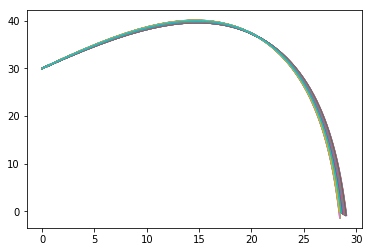

In [5]:
values = Struct()
values.angle    = 45.0  # degrees
values.velocity = 30.0  # m/s
values.gravity  = 9.8   # m/s^2
values.height   = 30   # m
values.mass     = 0.01  # kg
values.area     = np.pi * (0.05**2) # m^2

uncertainty = Struct()
uncertainty.angle    = 1    # degrees
uncertainty.velocity = 0.01 # m/s
uncertainty.gravity  = 0.01 # m/s^2
uncertainty.height   = 0    # m
uncertainty.mass     = 0    # kg
uncertainty.A        = 0    # m^2
uncertainty.C        = 0
uncertainty.p        = 0    # kg/m^3

runSimulation(values, uncertainty, Drag(A = values.area, p = 1.3), Settings(showHist=False))